In [1]:
import pandas as pd
import json
import jsonlines
from tqdm import tqdm
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pickle

In [2]:
def meli_loader(path, limit=None):
    rv = []
    item_count = 0
    for obj in tqdm(jsonlines.open(path)):
        rv.append(obj)
        if limit is not None and item_count > limit:
            break
        item_count += 1
    return pd.DataFrame(rv)


In [ ]:
df = meli_loader("meli-challenge-2019/spanish.test.jsonl", 100000)
df

In [ ]:
df.info()

In [ ]:
type(df["tokenized_title"][0])

## Breve análisis exploratorio

De la carga de datos podemos concluir:
- tokenized_title son las palabras del título saneadas. Queda revisar si se extrajeron los stop words
- data es un vector ralo de los tokens del título
- categrory y title también están vinculados. Siendo target una representación numérica de la categoría
- n_labels y size parece estar mas asociado al archivo que al contenido de la línea

### Analizando contenido y distribución

In [4]:
from utils.params import BASE_PATH
df = pd.read_pickle(BASE_PATH + "reduced_train_df.pkl")

In [5]:
df["category"].nunique()

100

In [6]:
cat_counts = df["category"].value_counts()

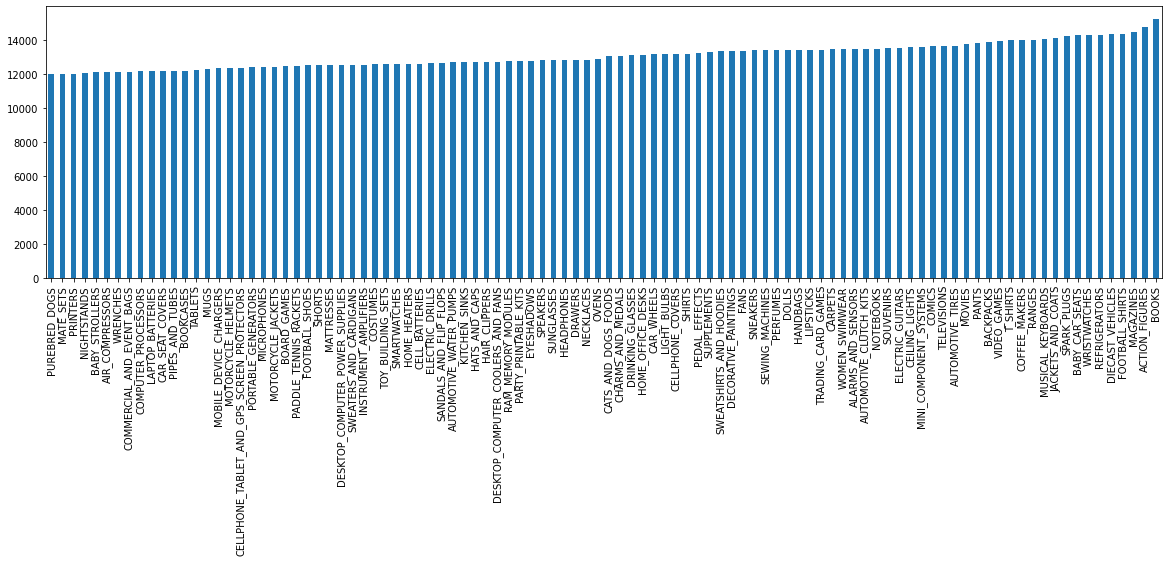

In [7]:
plt.figure(figsize=(20, 5))
cat_counts.sort_values().plot.bar()
plt.show()

Como esperábamos, hay una distribución desigual de las categorías. Con algunas categorías agrupando muchas muestras, y otras con un subconjunto muy menor. Este desbalance de clases, podría afectar a alguns modelos.

In [11]:
all_tokens = np.concatenate(df["tokenized_title"])
pd.Series(all_tokens).value_counts().sort_values(ascending=False)[:20]

kit         142396
original    138882
led         100793
negro        73750
juego        73700
mesa         73270
madera       67871
usb          67559
talle        65759
set          60209
luz          58863
acero        58293
oferta       56562
nuevo        56433
caja         55302
combo        55009
bateria      53910
pack         53651
blanco       51697
envio        50253
dtype: int64

Analizando las mayores ocurrencias en las listas de tokens, podemos asegurar que ya están limpias de stop words y sanitizadas

In [24]:
cnts = cat_counts[:100]

In [ ]:
top_cats = cnts.keys()

In [17]:
df[df["category"] in set(cat_counts[:100])]

TypeError: unhashable type: 'Series'

In [35]:
reduced_df = df[df["category"].isin(top_cats)]

In [36]:
reduced_df.to_pickle("reduced_train_df.pkl")

In [37]:
import pickle

In [38]:
with open("selected_top_cats.pkl", "wb") as f:
    pickle.dump(top_cats, f)

In [12]:
with open("model-data/selected_top_cats.pkl", "rb") as fp:
    top_cats = pickle.load(fp)

In [2]:
reduced_df = pd.read_pickle("model-data/reduced_train_df.pkl")

In [10]:
categories_map = dict(reduced_df[["target", "category"]].values)

In [15]:
categories_map[324]

'MOTORCYCLE_JACKETS'

In [16]:
with open("category_map.pkl", "wb") as fp:
    pickle.dump(categories_map, fp)

In [15]:
reduced_df[reduced_df["target"]==207]

,language,label_quality,title,category,split,tokenized_title,data,target,n_labels,size
259,spanish,unreliable,Procesador Intel 1151 8g Core I5 8400,COMPUTER_PROCESSORS,train,"[procesador, intel, core]","[1026, 517, 1025]",207,632,4895280
475,spanish,unreliable,"Procesadores De Cpu,amd A4-7300 Apu Dual Core ...",COMPUTER_PROCESSORS,train,"[procesadores, cpu, amd, apu, dual, core, proc...","[1714, 562, 559, 1713, 178, 1025, 1026]",207,632,4895280
724,spanish,reliable,Procesador Intel Core 2 Duo,COMPUTER_PROCESSORS,train,"[procesador, intel, core, duo]","[1026, 517, 1025, 25]",207,632,4895280
836,spanish,unreliable,Micro Intel Pentium 4 2.26ghz/2m/533/05a Sock...,COMPUTER_PROCESSORS,train,"[micro, intel, pentium, ghz, socket, slzh]","[1234, 517, 2645, 2644, 2646, 1]",207,632,4895280
1803,spanish,reliable,Microprocesador Intel Pentium 4 1.8 Ghz Sl5uk,COMPUTER_PROCESSORS,train,"[microprocesador, intel, pentium, ghz, sluk]","[4542, 517, 2645, 2644, 1]",207,632,4895280
...,...,...,...,...,...,...,...,...,...,...
4893597,spanish,unreliable,Procesador Amd Atlhon X2 7750 2.7ghz Dual Core...,COMPUTER_PROCESSORS,train,"[procesador, amd, atlhon, ghz, dual, core, soc...","[1026, 559, 41904, 2644, 178, 1025, 2646]",207,632,4895280
4893781,spanish,reliable,Microprocesador Intel I5-6400 1151 2.7ghz,COMPUTER_PROCESSORS,train,"[microprocesador, intel, ghz]","[4542, 517, 2644]",207,632,4895280
4893881,spanish,unreliable,Ryzen Threadripper Rt-2990wx 4.2 S/cool,COMPUTER_PROCESSORS,train,"[ryzen, threadripper, cool]","[5030, 42578, 3032]",207,632,4895280
4894026,spanish,unreliable,Micro Intel Pentium 4 520 Socket 775 2.8 Ghz O...,COMPUTER_PROCESSORS,train,"[micro, intel, pentium, socket, ghz, oportunidad]","[1234, 517, 2645, 2646, 2644, 893]",207,632,4895280
